# **Klasifikasi Jenis Sampah dengan Xception - CNN**
---

In [1]:
# File operations and data manipulation
import os, zipfile, shutil
from google.colab import drive
from shutil import copyfile

# Random number generation and numerical computations
import random
import numpy as np

# Visualization library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Deep learning framework and its modules
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras import layers
from keras import Model

# Ignore warnings during execution
import warnings
warnings.filterwarnings("ignore")

# Print TensorFlow version
print(tf.__version__)

2.14.0


## **Dataset Collection**
---

### Def list_directories
---

In [2]:
def list_directories(root_path):
  for rootdir, dirs, files in os.walk(root_path):
    for subdir in dirs:
      print(os.path.join(rootdir, subdir))

### Download Data
---

In [3]:
!wget --no-check-certificate \
  https://github.com/mrgsrylm/KlasifikasiSampah/releases/download/v1.0.0/data_organic_recyclable.zip \
  -O data_organic_recyclable.zip

!unzip data_organic_recyclable.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

### Dataset Source
---

In [4]:
DATASOURCE = 'DATASET'

## **Data Augmentation**
---

### Datagen from ImageDataGenerator
---

In [5]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.2,
                                   shear_range=0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   rotation_range = 40,
                                   fill_mode = 'nearest',
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

### Datasets
---
Flow training, validation and test images in batches of 64 using datagen generator

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = os.path.join(DATASOURCE, 'TRAIN'),
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64,
                                                   subset = 'training')

validation_dataset = valid_datagen.flow_from_directory(directory = os.path.join(DATASOURCE, 'TRAIN'),
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64,
                                                  subset = 'validation')

test_dataset = test_datagen.flow_from_directory(directory = os.path.join(DATASOURCE, 'TEST'),
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             batch_size = 64)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


## **Model Building**
---
Create Model using Convolutional Neural Network Xception Architecture

### Create Xception CNN Architecture (with Transfer Learning)
---

In [7]:
xception_pretrained_model = Xception(input_shape=(224, 224, 3),
                                include_top=False,
                                weights='imagenet')

for layer in xception_pretrained_model.layers:
    layer.trainable = False

xception_pretrained_model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [8]:
last_layer = xception_pretrained_model.get_layer('add_11')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 1024)


In [9]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2, activation='sigmoid')(x)

model = Model(xception_pretrained_model.input, x)

### Add Optimizer then compile model
---

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = [tf.keras.metrics.AUC(name = 'auc')])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.8 MB/s eta 0:00:00


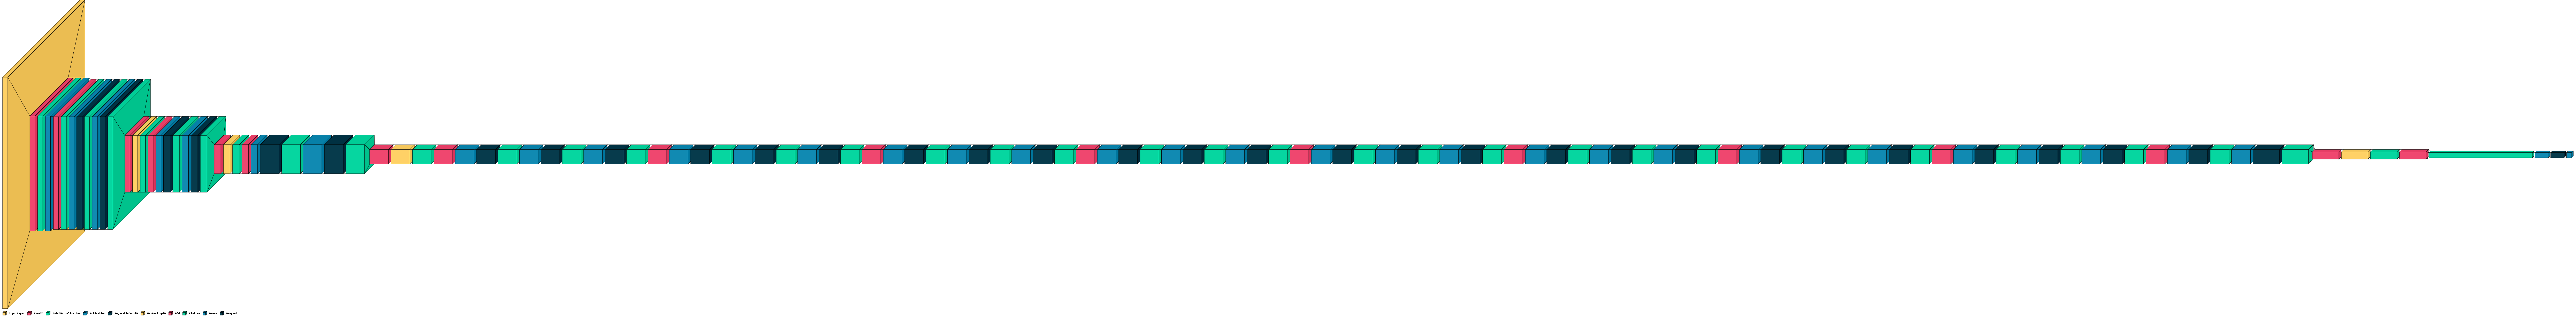

In [12]:
!pip install visualkeras
from visualkeras import layered_view
layered_view(model, legend=True)

## **Model Training**
---

In [13]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=20,
                    verbose=1)

Epoch 1/20
283/283 [==============================] - 327s 1s/step - loss: 0.9627 - auc: 0.9343 - val_loss: 0.2314 - val_auc: 0.9696
Epoch 2/20
283/283 [==============================] - 300s 1s/step - loss: 0.2236 - auc: 0.9696 - val_loss: 0.1575 - val_auc: 0.9850
Epoch 3/20
283/283 [==============================] - 291s 1s/step - loss: 0.2068 - auc: 0.9738 - val_loss: 0.1572 - val_auc: 0.9858
Epoch 4/20
283/283 [==============================] - 289s 1s/step - loss: 0.2005 - auc: 0.9750 - val_loss: 0.1454 - val_auc: 0.9876
Epoch 5/20
283/283 [==============================] - 288s 1s/step - loss: 0.1893 - auc: 0.9777 - val_loss: 0.1517 - val_auc: 0.9862
Epoch 6/20
283/283 [==============================] - 291s 1s/step - loss: 0.1872 - auc: 0.9785 - val_loss: 0.1702 - val_auc: 0.9829
Epoch 7/20
283/283 [==============================] - 293s 1s/step - loss: 0.1913 - auc: 0.9774 - val_loss: 0.1479 - val_auc: 0.9864
Epoch 8/20
283/283 [==============================] - 293s 1s/step - 

## **Model Evaluation**
---

### Plotting accuracy and loss Model
---

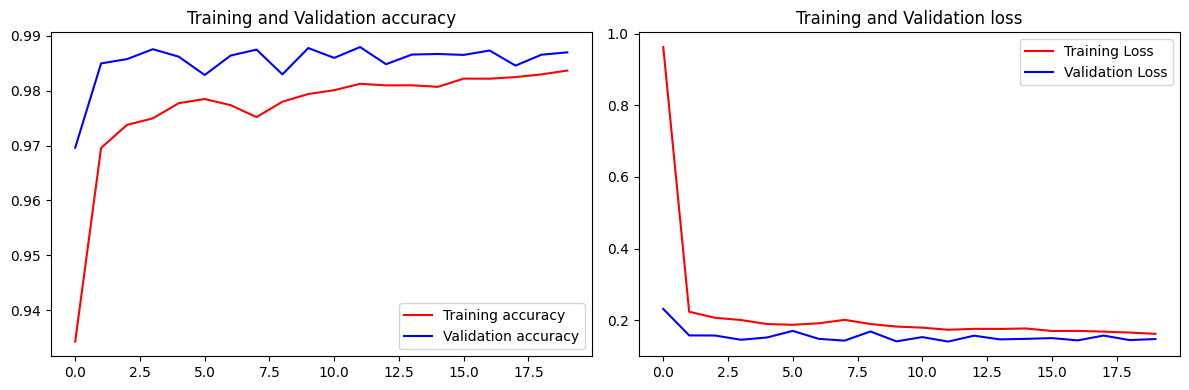

In [14]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Grapich
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(epochs, acc, 'r', label='Training accuracy')
axes[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axes[0].set_title('Training and Validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'r', label='Training Loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation Loss')
axes[1].set_title('Training and Validation loss')
axes[1].legend()

plt.tight_layout()
plt.show()

### Validation Accuracy
---

In [16]:
loss, accuracy = model.evaluate_generator(validation_dataset, steps=10, verbose=0)

print('Validation Accuracy: %.3f%%' % (accuracy * 100))
print('Validation Loss: %.3f%%' % (loss * 100))


Validation Accuracy: 98.598%
Validation Loss: 14.944%


### Test Accuracy
---

In [17]:
loss, accuracy = model.evaluate(test_dataset)

print('Test Accuracy: %.3f%%' % (accuracy * 100))
print('Test Loss: %.3f%%' % (loss * 100))

40/40 [==============================] - 10s 253ms/step - loss: 0.2206 - auc: 0.9710
Test Accuracy: 97.100%
Test Loss: 22.060%


## **Model Testing**
---

### Prediction
---

2/2 [==============================] - 3s 206ms/step
Prediction Accuracy: 93.75%


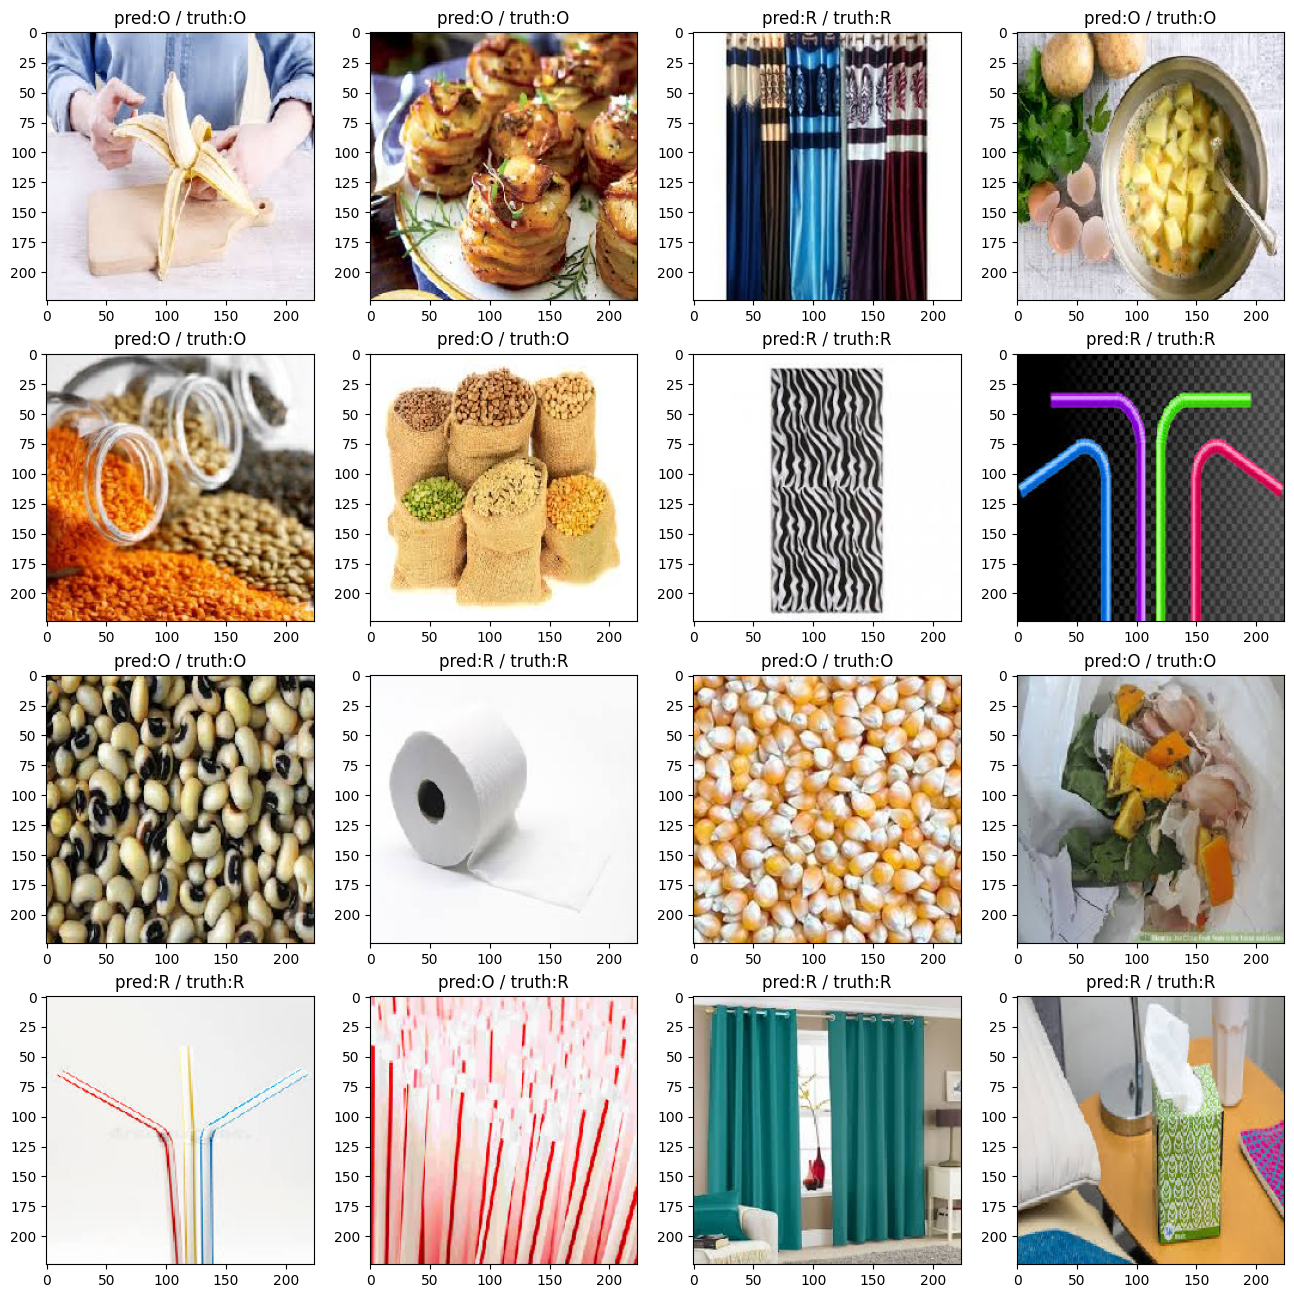

In [18]:
test_x, test_y = test_dataset.__getitem__(1)

labels = test_dataset.class_indices
labels = dict((v, k) for k, v in labels.items())

y_pred = model.predict(test_x)

plt.figure(figsize=(16, 16))
n = 16
count = 0

for i in range(n):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(y_pred[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
    if np.argmax(y_pred[i]) == np.argmax(test_y[i]):
        count += 1

accuracy = count / n * 100

print('Prediction Accuracy: {}%'.format(accuracy))

### Report
---

In [19]:
from sklearn.metrics import classification_report

test_x, test_y = test_dataset.__getitem__(1)

labels = test_dataset.class_indices
labels = dict((v, k) for k, v in labels.items())

y_pred = model.predict(test_x)

y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(test_y, axis=1)

print("Classification Report: ")
print(classification_report(true_classes, y_pred_classes, target_names=labels.values()))

2/2 [==============================] - 0s 180ms/step
Classification Report: 
              precision    recall  f1-score   support

           O       0.93      1.00      0.96        39
           R       1.00      0.88      0.94        25

    accuracy                           0.95        64
   macro avg       0.96      0.94      0.95        64
weighted avg       0.96      0.95      0.95        64



## **Model Storing**
---

### Save Model (h5)
---

In [20]:
!mkdir -p "saved_model"
!mkdir -p "tflite_model"
model.save('saved_model/model_xception_klasifikasi_jenis_sampah.h5')
# shutil.copy('model_xception_klasifikasi_sampah.hdf5', 'saved_model/model_xception_klasifikasi_jenis_sampah.h5')

### Save Model (TFLite)
---

In [21]:
tf.saved_model.save(model, export_dir="saved_model")

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_inception = converter.convert()

In [22]:
import pathlib
tflite_model_file = pathlib.Path("tflite_model/model_xception_klasifikasi_jenis_sampah.tflite")
tflite_model_file.write_bytes(tflite_model_inception)

42375424

### Save Model to Google Drive
---

In [23]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [24]:
# Model
source_saved_model= "/content/saved_model"
destination_saved_model = "/content/drive/My Drive/klasifikasi_sampah/jenis_sampah/xception/saved_model"
shutil.copytree(source_saved_model, destination_saved_model)

'/content/drive/My Drive/klasifikasi_sampah/jenis_sampah/xception/saved_model'

In [25]:
source_tflite_model = "/content/tflite_model"
destination_tflite_model = "/content/drive/My Drive/klasifikasi_sampah/jenis_sampah/xception/tflite_model"
shutil.copytree(source_tflite_model, destination_tflite_model)

'/content/drive/My Drive/klasifikasi_sampah/jenis_sampah/xception/tflite_model'

## Conclusion
---
1. Training Accuracy:
2. Validation Accuracy:
3. Testing Accuracy: